In [1]:
import gensim
from gensim.models import CoherenceModel

import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.parse.malt import MaltParser
from nltk.corpus import words
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

import html


import collections
from collections import defaultdict

import json

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jewel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jewel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jewel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jewel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
chatgpt_df = pd.read_csv("chatgpt-reddit.csv")

In [3]:
chatgpt_df.dropna(inplace=True)

In [4]:
chatgpt_df

,Unnamed: 0,subreddit_id,subreddit,id,author,body,created_utc
0,0,t5_7hqomg,ChatGPT,j6nffp0,eboeard-game-gom3,"Inspect element, change url to the Rick roll.",1675180774
1,1,t5_7hqomg,ChatGPT,j6nfezi,cromagnondan,I understand. I guess I never got much out of ...,1675180767
2,2,t5_7hqomg,ChatGPT,j6nfdyy,bacchusbastard,"The future holds new challenges and rewards, t...",1675180757
3,3,t5_7hqomg,ChatGPT,j6nfcab,calixan96,there's something wrong with american schools ...,1675180739
4,4,t5_7hqomg,ChatGPT,j6nfbjk,AutoModerator,In order to prevent multiple repetitive commen...,1675180731
...,...,...,...,...,...,...,...
61705,61705,t5_7hqomg,ChatGPT,j6ihrre,Due-Communication977,Check dm,1675094534
61706,61706,t5_7hqomg,ChatGPT,j6ihnfo,AutoModerator,In order to prevent multiple repetitive commen...,1675094486
61707,61707,t5_7hqomg,ChatGPT,j6ihlq8,xxylenn,you got some bold claims. so since youre so kn...,1675094467
61708,61708,t5_7hqomg,ChatGPT,j6ihhvc,skygate2012,They switched parties.,1675094425


In [5]:
"""
Code references:
    https://pythonguides.com/remove-unicode-characters-in-python/
    https://www.kite.com/python/answers/how-to-decode-html-entities-in-python
"""
def decode_text(text):
    # remove non-ASCII characters in string
    decoded_text = text.encode('ascii', 'ignore').decode('utf-8')

    # decode HTML entities
    decoded_html = html.unescape(decoded_text)
    return ''.join([word for word in decoded_html if word.isprintable()])

"""
Code reference:
    https://catriscode.com/2021/03/02/extracting-or-removing-mentions-and-hashtags-in-tweets-using-python/
"""
# def remove_mentions(text):
#     return re.sub("@[A-Za-z0-9_]+","", text)

def remove_stopwords(words_list):
    stop_list = stopwords.words("english")
    stop_list.append("filler")
    return [word for word in words_list if word not in stop_list]

def pos_to_wordnet(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_words(word_list):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # POS (part-of-speech) tagging
    # nltk_tagged -> a list of tuples (word, pos tag)
    nltk_tagged = nltk.pos_tag(word_list)

    # returns a list of tuples of words and their wordnet_tag (after conversion from NLTK tag)
    wordnet_tagged = list(map(lambda x: (x[0], pos_to_wordnet(x[1])), nltk_tagged))

    # lemmatizing
    lemmatized_words = []
    for word, tag in wordnet_tagged:
        if tag is not None:
            # need POS tag as 2nd argument as it helps lemmatize the words more accurately
            lemmatized_words.append(lemmatizer.lemmatize(word, tag))
        elif tag in [wordnet.NOUN]:
            lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

def clean_original_text(text):
    text = text.lower()
    clean_list = []
    sentence_list = nltk.sent_tokenize(text)
    for sentence in sentence_list:
        decoded_sentence = decode_text(sentence)
        words_list = nltk.RegexpTokenizer(r'\w+').tokenize(decoded_sentence)
        lemmatized_words = lemmatize_words(words_list)
        useful_words = remove_stopwords(lemmatized_words)

        if len(useful_words) > 0:
            clean_list.extend(useful_words)
    clean_text = ' '.join(clean_list)

    return clean_text

In [6]:
chatgpt_df["clean_text"] = chatgpt_df["body"].apply(clean_original_text)
chatgpt_df["clean_tokens"] = chatgpt_df["clean_text"].apply(nltk.word_tokenize)

In [7]:
chatgpt_df.drop(['Unnamed: 0'], axis=1, inplace=True)
chatgpt_df

,subreddit_id,subreddit,id,author,body,created_utc,clean_text,clean_tokens
0,t5_7hqomg,ChatGPT,j6nffp0,eboeard-game-gom3,"Inspect element, change url to the Rick roll.",1675180774,inspect element change url rick roll,"[inspect, element, change, url, rick, roll]"
1,t5_7hqomg,ChatGPT,j6nfezi,cromagnondan,I understand. I guess I never got much out of ...,1675180767,understand guess never get much write undergra...,"[understand, guess, never, get, much, write, u..."
2,t5_7hqomg,ChatGPT,j6nfdyy,bacchusbastard,"The future holds new challenges and rewards, t...",1675180757,future hold new challenge reward villain becom...,"[future, hold, new, challenge, reward, villain..."
3,t5_7hqomg,ChatGPT,j6nfcab,calixan96,there's something wrong with american schools ...,1675180739,something wrong american school ai never evalu...,"[something, wrong, american, school, ai, never..."
4,t5_7hqomg,ChatGPT,j6nfbjk,AutoModerator,In order to prevent multiple repetitive commen...,1675180731,order prevent multiple repetitive comment frie...,"[order, prevent, multiple, repetitive, comment..."
...,...,...,...,...,...,...,...,...
61705,t5_7hqomg,ChatGPT,j6ihrre,Due-Communication977,Check dm,1675094534,check dm,"[check, dm]"
61706,t5_7hqomg,ChatGPT,j6ihnfo,AutoModerator,In order to prevent multiple repetitive commen...,1675094486,order prevent multiple repetitive comment frie...,"[order, prevent, multiple, repetitive, comment..."
61707,t5_7hqomg,ChatGPT,j6ihlq8,xxylenn,you got some bold claims. so since youre so kn...,1675094467,get bold claim youre knowledgeable name commun...,"[get, bold, claim, youre, knowledgeable, name,..."
61708,t5_7hqomg,ChatGPT,j6ihhvc,skygate2012,They switched parties.,1675094425,switch party,"[switch, party]"


In [8]:
chatgpt_df.to_csv("chatgpt-reddit-clean.csv")

Build LDA model

In [9]:
chatgpt_clean_df = pd.read_csv("chatgpt-reddit-clean.csv")

In [10]:
chatgpt_clean_df

,Unnamed: 0,subreddit_id,subreddit,id,author,body,created_utc,clean_text,clean_tokens
0,0,t5_7hqomg,ChatGPT,j6nffp0,eboeard-game-gom3,"Inspect element, change url to the Rick roll.",1675180774,inspect element change url rick roll,"['inspect', 'element', 'change', 'url', 'rick'..."
1,1,t5_7hqomg,ChatGPT,j6nfezi,cromagnondan,I understand. I guess I never got much out of ...,1675180767,understand guess never get much write undergra...,"['understand', 'guess', 'never', 'get', 'much'..."
2,2,t5_7hqomg,ChatGPT,j6nfdyy,bacchusbastard,"The future holds new challenges and rewards, t...",1675180757,future hold new challenge reward villain becom...,"['future', 'hold', 'new', 'challenge', 'reward..."
3,3,t5_7hqomg,ChatGPT,j6nfcab,calixan96,there's something wrong with american schools ...,1675180739,something wrong american school ai never evalu...,"['something', 'wrong', 'american', 'school', '..."
4,4,t5_7hqomg,ChatGPT,j6nfbjk,AutoModerator,In order to prevent multiple repetitive commen...,1675180731,order prevent multiple repetitive comment frie...,"['order', 'prevent', 'multiple', 'repetitive',..."
...,...,...,...,...,...,...,...,...,...
61698,61705,t5_7hqomg,ChatGPT,j6ihrre,Due-Communication977,Check dm,1675094534,check dm,"['check', 'dm']"
61699,61706,t5_7hqomg,ChatGPT,j6ihnfo,AutoModerator,In order to prevent multiple repetitive commen...,1675094486,order prevent multiple repetitive comment frie...,"['order', 'prevent', 'multiple', 'repetitive',..."
61700,61707,t5_7hqomg,ChatGPT,j6ihlq8,xxylenn,you got some bold claims. so since youre so kn...,1675094467,get bold claim youre knowledgeable name commun...,"['get', 'bold', 'claim', 'youre', 'knowledgeab..."
61701,61708,t5_7hqomg,ChatGPT,j6ihhvc,skygate2012,They switched parties.,1675094425,switch party,"['switch', 'party']"


In [11]:
# Helper function
def docs2vecs(docs, dictionary):
    # docs is a list of documents returned by corpus2docs.
    # dictionary is a gensim.corpora.Dictionary object.
    vecs = [dictionary.doc2bow(doc) for doc in docs]
    return vecs

In [12]:
chatgptreddit_docs = [ast.literal_eval(doc) for doc in chatgpt_clean_df["clean_tokens"]]
chatgptreddit_dict = gensim.corpora.Dictionary(chatgptreddit_docs)
chatgptreddit_vecs = docs2vecs(chatgptreddit_docs, chatgptreddit_dict)

In [13]:
chatgptreddit_lda = gensim.models.ldamodel.LdaModel(corpus=chatgptreddit_vecs, id2word=chatgptreddit_dict, num_topics=10)

In [14]:
topics = chatgptreddit_lda.show_topics(5, 10)

for i in range(0, 5):
    print(topics[i])

(4, '0.029*"write" + 0.021*"people" + 0.021*"get" + 0.019*"make" + 0.019*"want" + 0.018*"think" + 0.017*"go" + 0.016*"use" + 0.014*"really" + 0.013*"trump"')
(6, '0.026*"die" + 0.021*"source" + 0.019*"add" + 0.017*"exist" + 0.016*"internet" + 0.015*"shit" + 0.014*"planet" + 0.014*"story" + 0.014*"line" + 0.013*"rather"')
(7, '0.026*"prompt" + 0.026*"com" + 0.025*"opinion" + 0.021*"create" + 0.020*"character" + 0.019*"find" + 0.019*"correct" + 0.018*"try" + 0.016*"http" + 0.016*"use"')
(3, '0.025*"lol" + 0.021*"google" + 0.020*"response" + 0.018*"replace" + 0.017*"george" + 0.017*"base" + 0.015*"error" + 0.015*"business" + 0.015*"back" + 0.013*"also"')
(9, '0.060*"ai" + 0.032*"work" + 0.031*"human" + 0.022*"use" + 0.017*"mean" + 0.012*"student" + 0.012*"system" + 0.011*"chatgpt" + 0.011*"large" + 0.010*"good"')


Calculate coherence score of LDA model

In [15]:
coherence_model_lda = CoherenceModel(model=chatgptreddit_lda, texts=chatgptreddit_docs, dictionary=chatgptreddit_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAModel: ', coherence_lda)


Coherence Score LDAModel:  0.4268734542266578


In [16]:
model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10, 1):
    chatgptreddit_lda = gensim.models.ldamodel.LdaModel(corpus=chatgptreddit_vecs, id2word=chatgptreddit_dict, num_topics=num_topics)
    coherence_model = CoherenceModel(model=chatgptreddit_lda, texts=chatgptreddit_docs, dictionary=chatgptreddit_dict, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(chatgptreddit_lda)
    coherence_values.append(coherence_model.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherence_model.get_coherence()))

#Topics: 2 Score: 0.7537525682197688
#Topics: 3 Score: 0.6137266373484996
#Topics: 4 Score: 0.5618177288532484
#Topics: 5 Score: 0.5300155722190727
#Topics: 6 Score: 0.46840478677779646
#Topics: 7 Score: 0.46134000357371424
#Topics: 8 Score: 0.4403807706371006
#Topics: 9 Score: 0.45156025411105044


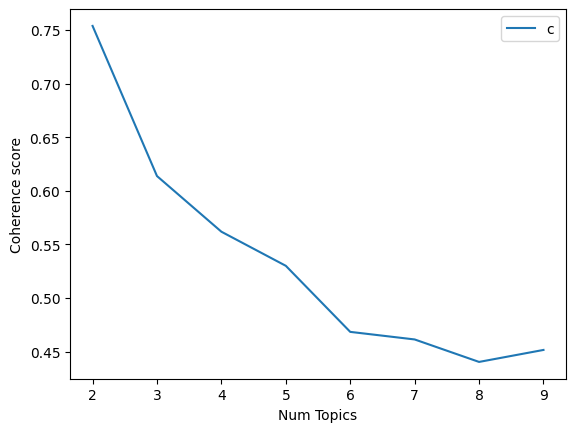

In [17]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
num_topics = 0
highest_coherence_value = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if round(cv, 4) > highest_coherence_value:
        highest_coherence_value = round(cv, 4)
        num_topics = m

print("Optimal topics:", num_topics)

chosen_model = model_list[num_topics-2]
print("Chosen model:", chosen_model)

Num Topics = 2  has Coherence Value of 0.7538
Num Topics = 3  has Coherence Value of 0.6137
Num Topics = 4  has Coherence Value of 0.5618
Num Topics = 5  has Coherence Value of 0.53
Num Topics = 6  has Coherence Value of 0.4684
Num Topics = 7  has Coherence Value of 0.4613
Num Topics = 8  has Coherence Value of 0.4404
Num Topics = 9  has Coherence Value of 0.4516
Optimal topics: 2
Chosen model: LdaModel<num_terms=7392, num_topics=2, decay=0.5, chunksize=2000>


Generate popular topics and terms of LDA model

In [19]:
topic_terms_dict = defaultdict(list)

# num_topics = 9 because that is the number of topics that our chosen model has
for topic_id, terms_list in chosen_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    topic_terms_dict[str(topic_id)] = [term[0] for term in terms_list]
topic_terms_dict = dict(topic_terms_dict)

topic_terms_dict

{'0': ['chatgpt',
  'discord',
  'use',
  'bot',
  'https',
  'comment',
  'moderator',
  'yes',
  'free',
  'question'],
 '1': ['use',
  'ai',
  'make',
  'know',
  'chatgpt',
  'ask',
  'work',
  'give',
  'say',
  'get']}

In [ ]:
with open("chatgpt_reddit_topics.json", "w") as new_file:
    json.dump(topic_terms_dict, new_file, indent=4)